In [ ]:
import pandas as pd
import numpy as np

# !pip install geopandas
# import geopandas as gpd
# from shapely.geometry import Point
# from pyproj import Proj, transform
import matplotlib.pyplot as plt

import urllib
import os
import requests
import zipfile
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [ ]:
cuision = dict()
cuision['Asian/Asian Fusion'] = ['Chinese/Cuban','Chinese/Japanese','Indonesian','Southeast Asian','Thai','Bangladeshi','Filipino']
cuision['Fuision'] = ['Asian/Asian Fusion','Fusion','New American']
cuision['Korean/Japanese'] = ['Korean','Japanese']
cuision['Indian'] = ['Indian']
cuision['Chinese'] = ['Chinese']
cuision['Central Asian'] = ['Afghan','Pakistani','Middle Eastern','Iranian','Mediterranean','Turkish']
cuision['Bakery/Desserts'] = ['Bagels/Pretzels','Bakery Products/Desserts','Donuts','Basque','Pancakes/Waffles','Frozen Desserts','Nuts/Confectionary']
cuision['Beverages'] = ['Bottled Beverages','Coffee/Tea']
cuision['Pizza/Hotdogs/Chicken'] = ['Pizza','Hotdogs','Hamburgers','Chicken','Hotdogs/Pretzels']
cuision['African'] = ['African','Ethiopian','Lebanese','Moroccan','Egyptian']
cuision['Latin American'] = ['Peruvian','Mexican','Brazilian','Caribbean','Latin American','Chilean']
cuision['American'] = ['American','Tex-Mex','Creole','Cajun','Californian','Southwestern','Soul Food','Hawaiian','Creole/Cajun']
cuision['Vegan/Fruit'] = ['Fruits/Vegetables','Juice, Smoothies, Fruit Salads','Salads','Sandwiches','Soups/Salads/Sandwiches',
                          'Vegan','Vegetarian','Soups','Sandwiches/Salads/Mixed Buffet']
cuision['Protein'] = ['Steakhouse','Barbecue','Seafood',]
cuision['European'] = ['Armenian','Czech','Polish','Scandinavian','Greek','Eastern European','Irish','Russian','English','Continental']
cuision['South European'] = ['French','Spanish','Italian','German','Tapas','Portuguese','New French']
cuision['Other'] = ['Other','Not Listed/Not Applicable']
cuision['Jewish/Kosher'] = ['Jewish/Kosher']
cuision['Australian'] = ['Australian']

In [ ]:
path = 'cleanData2_withDummy.csv'
violation = pd.read_csv(path).iloc[:,1:]

exclude_col = ['CAMIS','DBA','BORO','INSPECTION DATE','SCORE','INSPECTION TYPE','Latitude', 'Longitude','geometry']
cuision_new = []
for cui in violation['CUISINE DESCRIPTION'].values:
    add = ''
    for k,v in cuision.items():
        if cui in v:
            add = add + k
    cuision_new.append(add)
violation['CUISINE DESCRIPTION'] = cuision_new

violation = violation.loc[:,~violation.columns.isin(exclude_col)]
violation = violation[violation.GRADE.isin(['A','B','C'])].reset_index().iloc[:,1:]
violation['GRADE1'] = violation.GRADE.apply( lambda x: x if x=='A' else 'Not A' )

#data sampling
# violation = violation.groupby("GRADE").sample(n=min(violation.GRADE.value_counts()), random_state=1)

In [ ]:
# violation.to_csv('clean3_withDummy.csv',index=False)

## Neural Network

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense,SimpleRNN
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
X = pd.get_dummies(violation.loc[:,~violation.columns.isin(['GRADE','GRADE1'])])
y = violation.loc[:,'GRADE']

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc,le

def dataTransform(X,y,method='SME'):
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

    # data sampling after train test splitting
    # define oversampling strategy

    # over = SMOTE()
    # over_ada = ADASYN()
    # under = RandomUnderSampler(sampling_strategy={'A':0.5})
    # steps = [('o', over), ('u', under)]
    # pipeline = Pipeline(steps=steps)
    if method == 'SME':
        resample_sm = SMOTEENN(random_state=42)
    if method =='SMT':
        resample_sm = SMOTETomek(random_state=42)

    # fit and apply the transform
    X_train, y_train = resample_sm.fit_resample(X_train, y_train)

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # summarize
    print('Train', X_train.shape, y_train.shape)
    print('Test', X_test.shape, y_test.shape)
    
    # prepare output data
    y_train_enc, y_test_enc,le = prepare_targets(y_train, y_test)
    return X_train, X_test, y_train_enc, y_test_enc,le,scaler

In [ ]:
#Categorical Feature Selection
# feature selection
def select_features(method, k_num, X_train, y_train, X_test):
    fs = SelectKBest(score_func=method, k=k_num) 
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
# X_train_fs, X_test_fs, fs = select_features(mutual_info_classif, 6, X_train, y_train_enc, X_test)#chi2
# # what are scores for the features
# cols = X.columns.values
# for i in range(len(fs.scores_)):
#     print('Feature %d %s: %f' % (i, cols[i], fs.scores_[i]))

### **Try Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train_enc)
pred = dt.predict(X_test)
# in sample accuracy
print('In sample accuracy:',dt.score(X_train,y_train_enc))

# out of sample accuracy
print('Out of sample accuracy:',dt.score(X_test,y_test_enc))

from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test_enc, pred))

In sample accuracy: 0.9986470127465641
Out of sample accuracy: 0.8294054633101232
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      3335
           1       0.24      0.31      0.27       290
           2       0.18      0.31      0.23       109

    accuracy                           0.83      3734
   macro avg       0.45      0.51      0.47      3734
weighted avg       0.86      0.83      0.84      3734



## MLP with MultiLabel (SMOTETomek)

In [ ]:
X = pd.get_dummies(violation.loc[:,~violation.columns.isin(['GRADE','GRADE1'])])
y = violation.loc[:,'GRADE']

X_train, X_test, y_train_enc, y_test_enc,le = dataTransform(X,y,method='SMT')

# Keras needs the labels as categorical matrics.
y_train_pp = np_utils.to_categorical(y_train_enc)
y_test_pp = np_utils.to_categorical(y_test_enc)
num_classes = y_test_pp.shape[1]

# feature selection
# X_train_fs, X_test_fs, fs = select_features(mutual_info_classif, 20, X_train, y_train_enc, X_test)#chi2

np.random.seed(2019)
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(units=15, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Train (35553, 101) (35553,)
Test (4667, 101) (4667,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                5100      
                                                                 
 dense_5 (Dense)             (None, 15)                765       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 5)                 80        
                                                                 
 dense_7 (Dense)             (None, 3)                 18        
                                                                 
Total params: 5,963
Trainable params: 5,963
Non-trainable params: 0
_________________________________________________________________

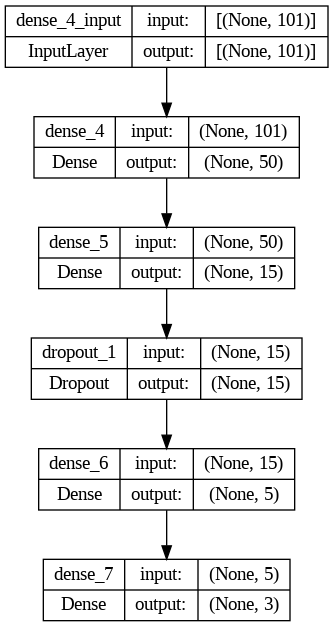

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True,)

In [ ]:
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train_pp, validation_data=(X_test, y_test_pp), epochs=50, verbose=2, batch_size=32)

Epoch 1/50
1112/1112 - 2s - loss: 0.9294 - accuracy: 0.5497 - val_loss: 0.6316 - val_accuracy: 0.7853 - 2s/epoch - 2ms/step
Epoch 2/50
1112/1112 - 2s - loss: 0.7050 - accuracy: 0.6679 - val_loss: 0.4775 - val_accuracy: 0.8534 - 2s/epoch - 2ms/step
Epoch 3/50
1112/1112 - 2s - loss: 0.6273 - accuracy: 0.7043 - val_loss: 0.4442 - val_accuracy: 0.8674 - 2s/epoch - 2ms/step
Epoch 4/50
1112/1112 - 2s - loss: 0.5991 - accuracy: 0.7199 - val_loss: 0.4235 - val_accuracy: 0.8699 - 2s/epoch - 2ms/step
Epoch 5/50
1112/1112 - 4s - loss: 0.5797 - accuracy: 0.7308 - val_loss: 0.4180 - val_accuracy: 0.8725 - 4s/epoch - 4ms/step
Epoch 6/50
1112/1112 - 6s - loss: 0.5639 - accuracy: 0.7386 - val_loss: 0.4098 - val_accuracy: 0.8759 - 6s/epoch - 5ms/step
Epoch 7/50
1112/1112 - 4s - loss: 0.5466 - accuracy: 0.7458 - val_loss: 0.4023 - val_accuracy: 0.8777 - 4s/epoch - 4ms/step
Epoch 8/50
1112/1112 - 5s - loss: 0.5331 - accuracy: 0.7519 - val_loss: 0.4000 - val_accuracy: 0.8757 - 5s/epoch - 4ms/step
Epoch 9/

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title('Training and Validation {}'.format(metric))
    plt.legend([metric, 'val_'+metric])

In [ ]:
#MultiLabel with dropout 0.1
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob,multi_class='ovr')

146/146 [==============================] - 0s 2ms/step
Accuracy Rate: 0.873580
              precision    recall  f1-score   support

           A       0.96      0.93      0.94      4172
           B       0.33      0.40      0.36       356
           C       0.25      0.33      0.29       139

    accuracy                           0.87      4667
   macro avg       0.51      0.55      0.53      4667
weighted avg       0.89      0.87      0.88      4667



0.8567714382147917

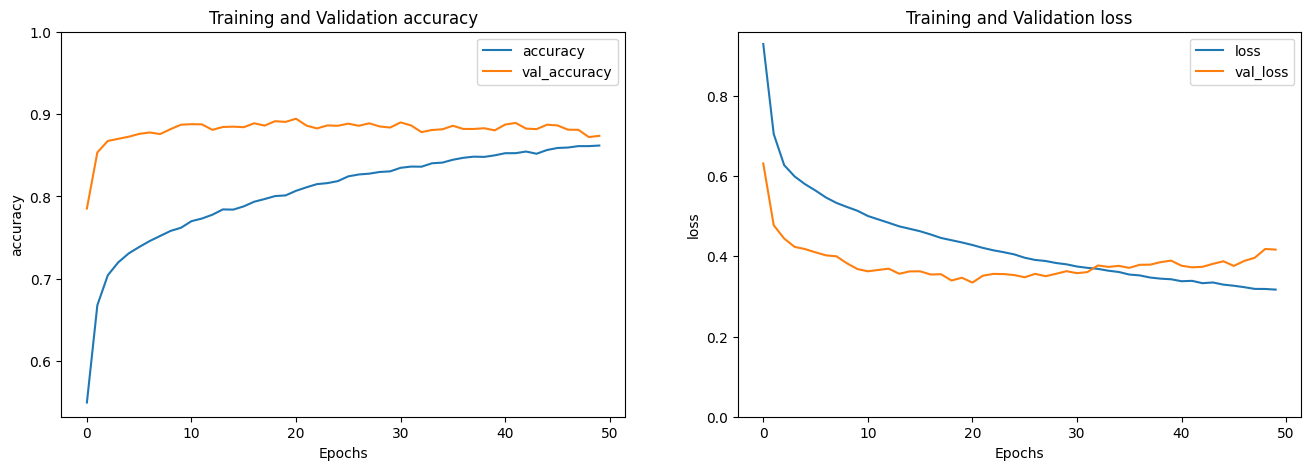

In [ ]:
#MultiLabel with dropout 0.1
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
#MultiLabel with dropout 0.2
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob,multi_class='ovr')

146/146 [==============================] - 0s 2ms/step
Accuracy Rate: 0.889436
              precision    recall  f1-score   support

           A       0.95      0.95      0.95      4172
           B       0.42      0.31      0.36       356
           C       0.31      0.50      0.38       139

    accuracy                           0.89      4667
   macro avg       0.56      0.59      0.56      4667
weighted avg       0.89      0.89      0.89      4667



0.892532138304326

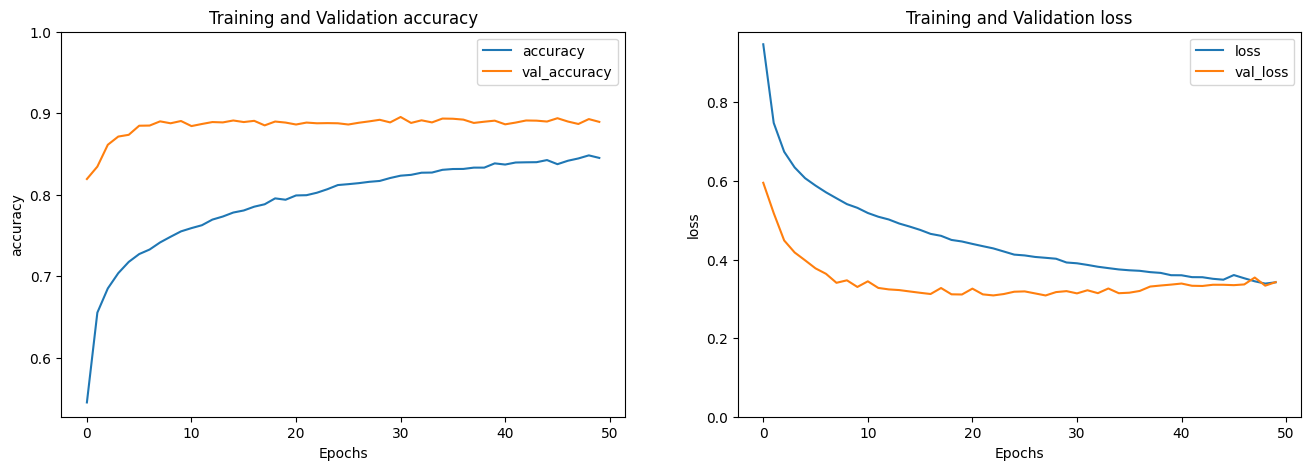

In [ ]:
#MultiLabel with dropout 0.2
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

## MLP with Binary Label (SMOTEENN)

In [ ]:
X = pd.get_dummies(violation.loc[:,~violation.columns.isin(['GRADE','GRADE1'])])
y = violation.loc[:,'GRADE1']

X_train, X_test, y_train_enc, y_test_enc,le = dataTransform(X,y,method='SME')

Train (20112, 101) (20112,)
Test (4667, 101) (4667,)


In [ ]:
# Keras needs the labels as categorical matrics.
y_train_pp = np_utils.to_categorical(y_train_enc)
y_test_pp = np_utils.to_categorical(y_test_enc)
num_classes = y_test_pp.shape[1]

# feature selection
# X_train_fs, X_test_fs, fs = select_features(mutual_info_classif, 20, X_train, y_train_enc, X_test)#chi2

np.random.seed(2019)
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(units=15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train_pp, validation_data=(X_test, y_test_pp), epochs=50, verbose=2, batch_size=32)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 50)                5100      
                                                                 
 dense_41 (Dense)            (None, 15)                765       
                                                                 
 dropout_10 (Dropout)        (None, 15)                0         
                                                                 
 dense_42 (Dense)            (None, 5)                 80        
                                                                 
 dense_43 (Dense)            (None, 2)                 12        
                                                                 
Total params: 5,957
Trainable params: 5,957
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
629/629 - 2s - loss: 0.6304 - accur

In [ ]:
### Binary Classification with Dropout 0.2
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 1ms/step
Accuracy Rate: 0.918577
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4172
           1       0.61      0.63      0.62       495

    accuracy                           0.92      4667
   macro avg       0.78      0.79      0.79      4667
weighted avg       0.92      0.92      0.92      4667



0.7906514812555081

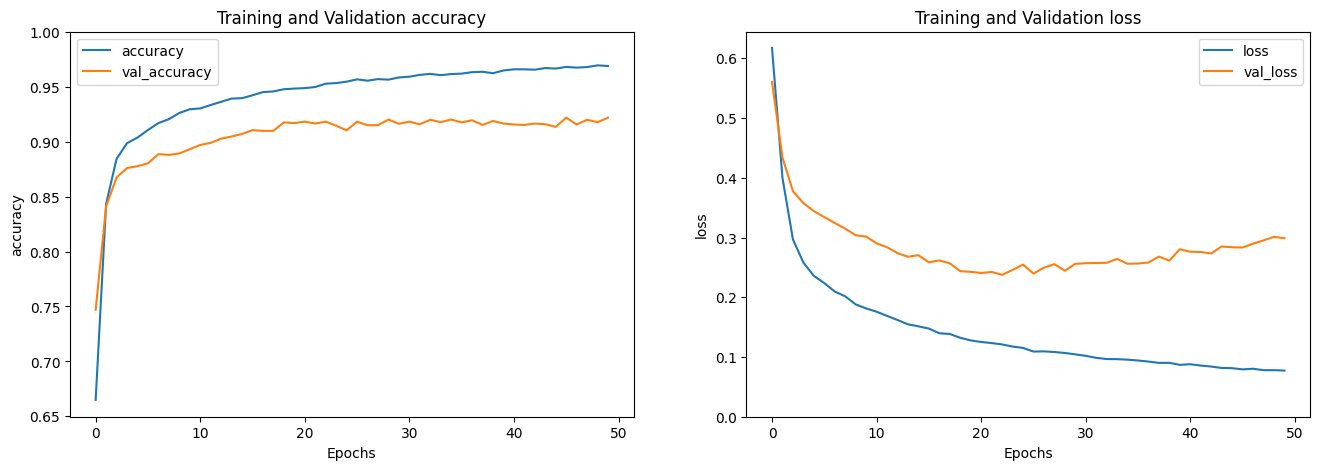

In [ ]:
### Binary Classification with Dropout 0.2
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
### Binary Classification with Dropout 0.3
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 1ms/step
Accuracy Rate: 0.916863
              precision    recall  f1-score   support

           A       0.96      0.95      0.95      4172
       Not A       0.60      0.63      0.62       495

    accuracy                           0.92      4667
   macro avg       0.78      0.79      0.78      4667
weighted avg       0.92      0.92      0.92      4667



0.7905829628983992

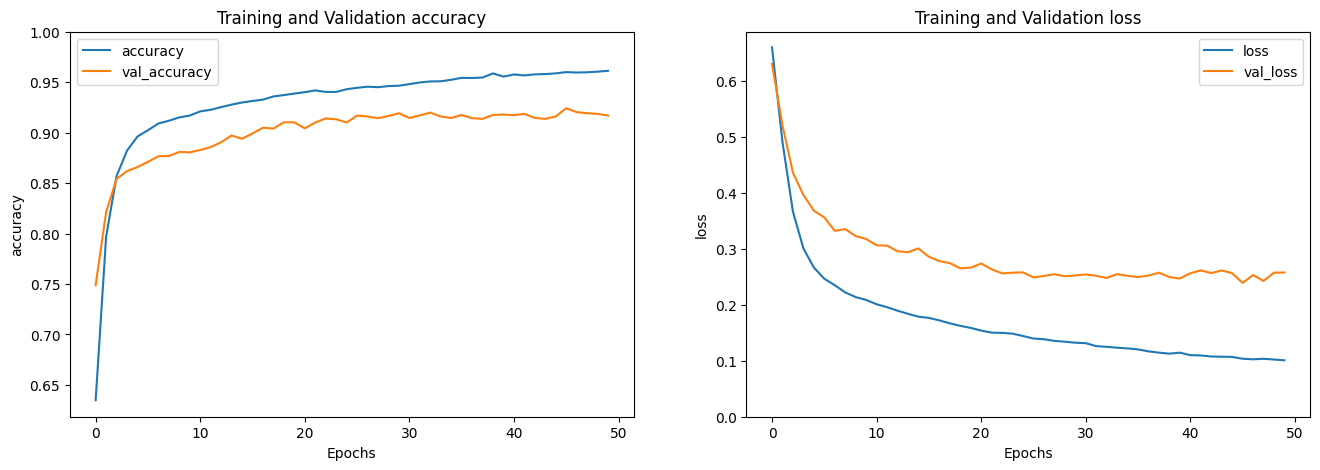

In [ ]:
### Binary Classification with Dropout 0.3
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
### Binary Classification with Dropout 0.4
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 2ms/step
Accuracy Rate: 0.915149
              precision    recall  f1-score   support

           A       0.96      0.95      0.95      4172
       Not A       0.59      0.65      0.62       495

    accuracy                           0.92      4667
   macro avg       0.77      0.80      0.79      4667
weighted avg       0.92      0.92      0.92      4667



0.8003072430924779

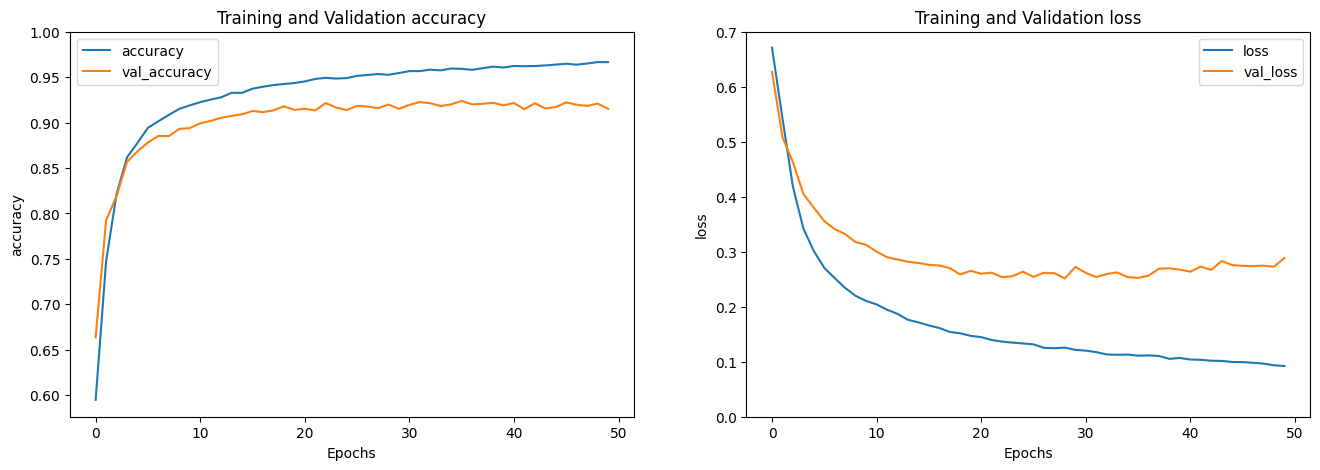

In [ ]:
### Binary Classification with Dropout 0.4
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
### Binary Classification with Dropout 0.5
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 1ms/step
Accuracy Rate: 0.922648
              precision    recall  f1-score   support

           A       0.96      0.95      0.96      4172
       Not A       0.63      0.67      0.65       495

    accuracy                           0.92      4667
   macro avg       0.79      0.81      0.80      4667
weighted avg       0.93      0.92      0.92      4667



0.8134044181024046

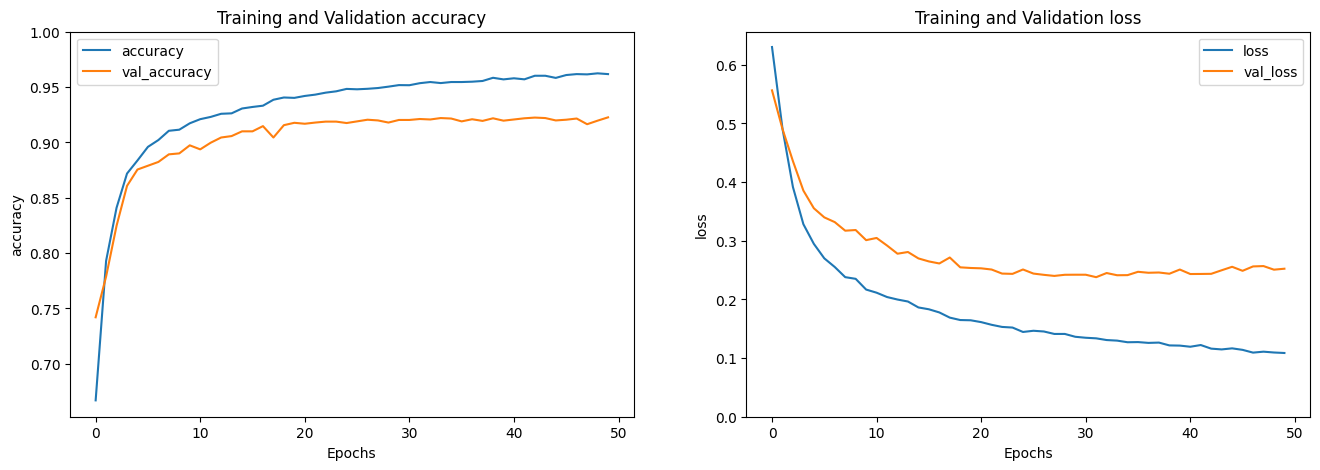

In [ ]:
### Binary Classification with Dropout 0.5
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

## MLP with Binary Label (SMOTETomek)

In [ ]:
X = pd.get_dummies(violation.loc[:,~violation.columns.isin(['GRADE','GRADE1'])])
y = violation.loc[:,'GRADE1']

X_train, X_test, y_train_enc, y_test_enc,le,scaler = dataTransform(X,y,method='SMT')

Train (24790, 101) (24790,)
Test (4667, 101) (4667,)


In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title('Training and Validation {}'.format(metric))
    plt.legend([metric, 'val_'+metric])

In [ ]:
# Keras needs the labels as categorical matrics.
y_train_pp = np_utils.to_categorical(y_train_enc)
y_test_pp = np_utils.to_categorical(y_test_enc)
num_classes = y_test_pp.shape[1]

# feature selection
# X_train_fs, X_test_fs, fs = select_features(mutual_info_classif, 20, X_train, y_train_enc, X_test)#chi2

np.random.seed(2019)
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(units=15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train_pp, validation_data=(X_test, y_test_pp), epochs=50, verbose=2, batch_size=32)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 50)                5100      
                                                                 
 dense_21 (Dense)            (None, 15)                765       
                                                                 
 dropout_5 (Dropout)         (None, 15)                0         
                                                                 
 dense_22 (Dense)            (None, 5)                 80        
                                                                 
 dense_23 (Dense)            (None, 2)                 12        
                                                                 
Total params: 5,957
Trainable params: 5,957
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
775/775 - 3s - loss: 0.6735 - accura

In [ ]:
### Binary Classification with Dropout 0.2
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 1ms/step
Accuracy Rate: 0.928434
              precision    recall  f1-score   support

           A       0.98      0.94      0.96      4172
       Not A       0.63      0.81      0.71       495

    accuracy                           0.93      4667
   macro avg       0.80      0.88      0.83      4667
weighted avg       0.94      0.93      0.93      4667



0.8753970675111614

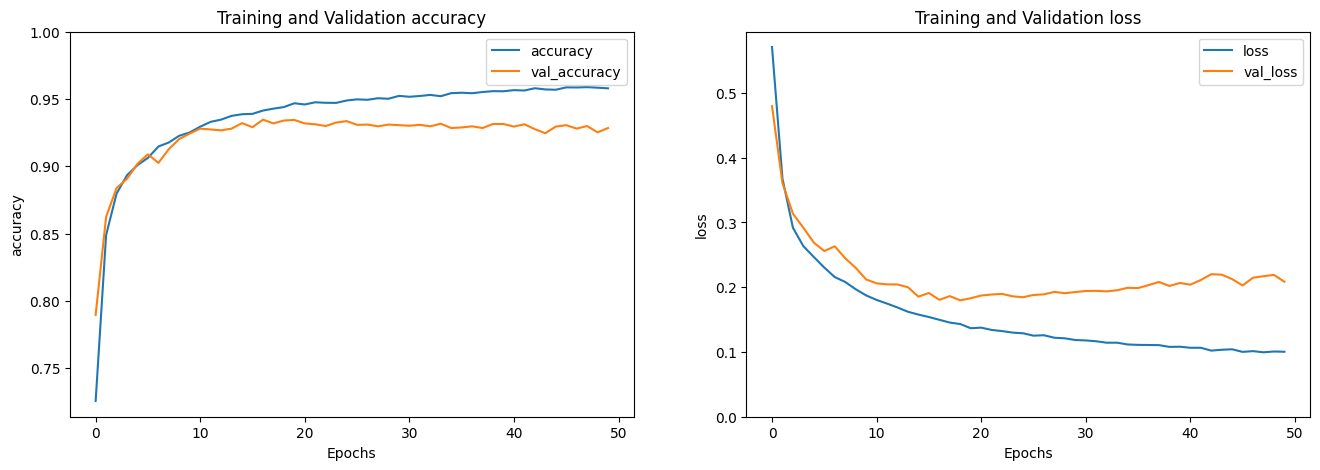

In [ ]:
### Binary Classification with Dropout 0.2
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
### Binary Classification with Dropout 0.3
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 2ms/step
Accuracy Rate: 0.921791
              precision    recall  f1-score   support

           A       0.98      0.94      0.96      4172
       Not A       0.60      0.81      0.69       495

    accuracy                           0.92      4667
   macro avg       0.79      0.87      0.82      4667
weighted avg       0.94      0.92      0.93      4667



0.8725720774378494

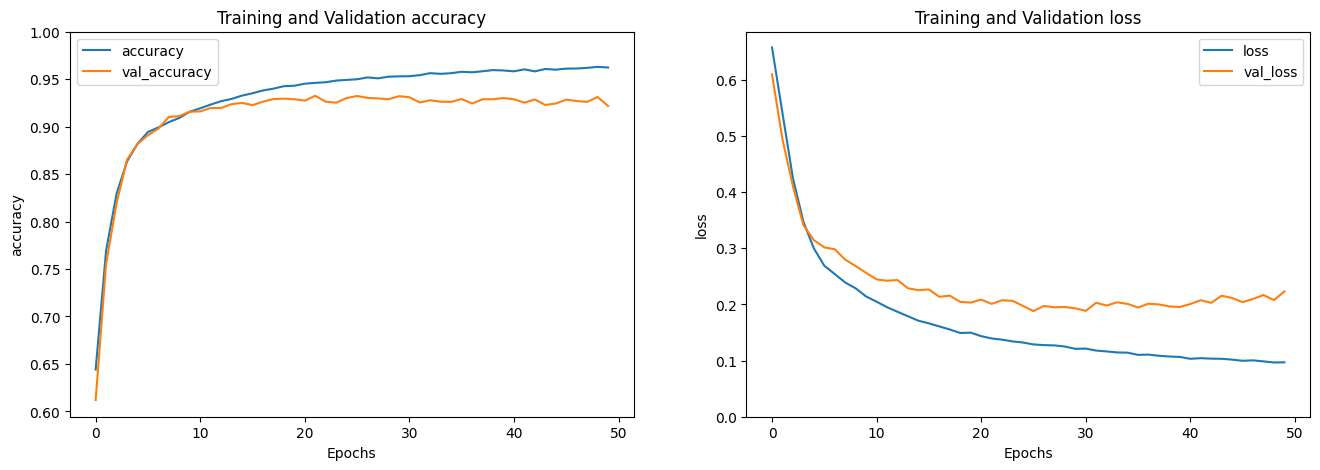

In [ ]:
### Binary Classification with Dropout 0.3
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
### Binary Classification with Dropout 0.4
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 1ms/step
Accuracy Rate: 0.927791
              precision    recall  f1-score   support

           A       0.98      0.94      0.96      4172
       Not A       0.62      0.83      0.71       495

    accuracy                           0.93      4667
   macro avg       0.80      0.88      0.83      4667
weighted avg       0.94      0.93      0.93      4667



0.8839400718595349

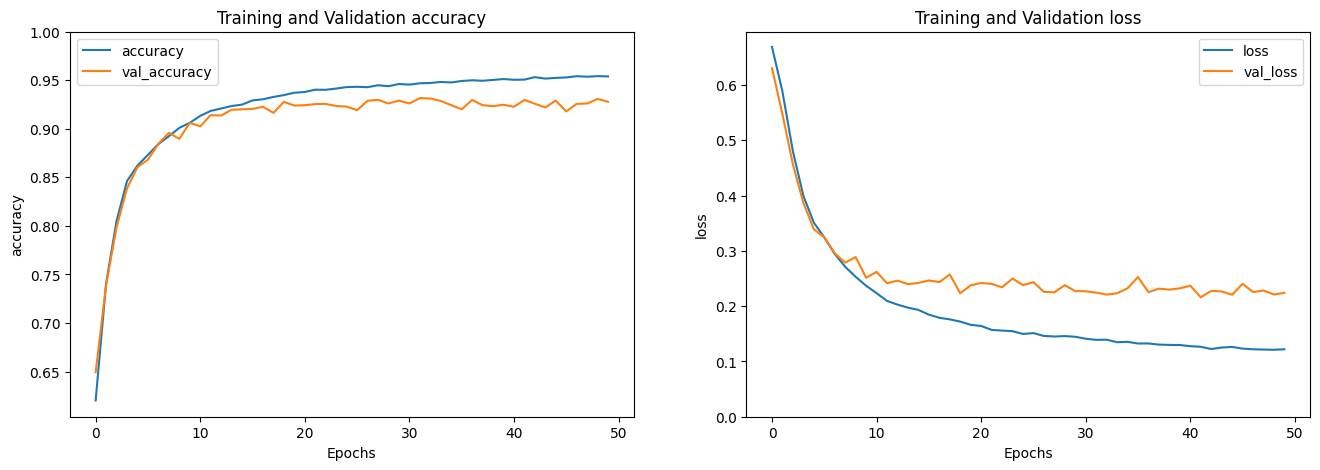

In [ ]:
### Binary Classification with Dropout 0.4
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

In [ ]:
### Binary Classification with Dropout 0.5
prob = model.predict(X_test)
print('Accuracy Rate: %f' % accuracy_score(y_test_enc, prob.argmax(axis = 1)))
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(prob.argmax(axis = 1))))
roc_auc_score(y_test_enc, prob.argmax(axis = 1)) #,multi_class='ovr'

146/146 [==============================] - 0s 2ms/step
Accuracy Rate: 0.929719
              precision    recall  f1-score   support

           A       0.97      0.95      0.96      4172
       Not A       0.64      0.77      0.70       495

    accuracy                           0.93      4667
   macro avg       0.81      0.86      0.83      4667
weighted avg       0.94      0.93      0.93      4667



0.8600915676419032

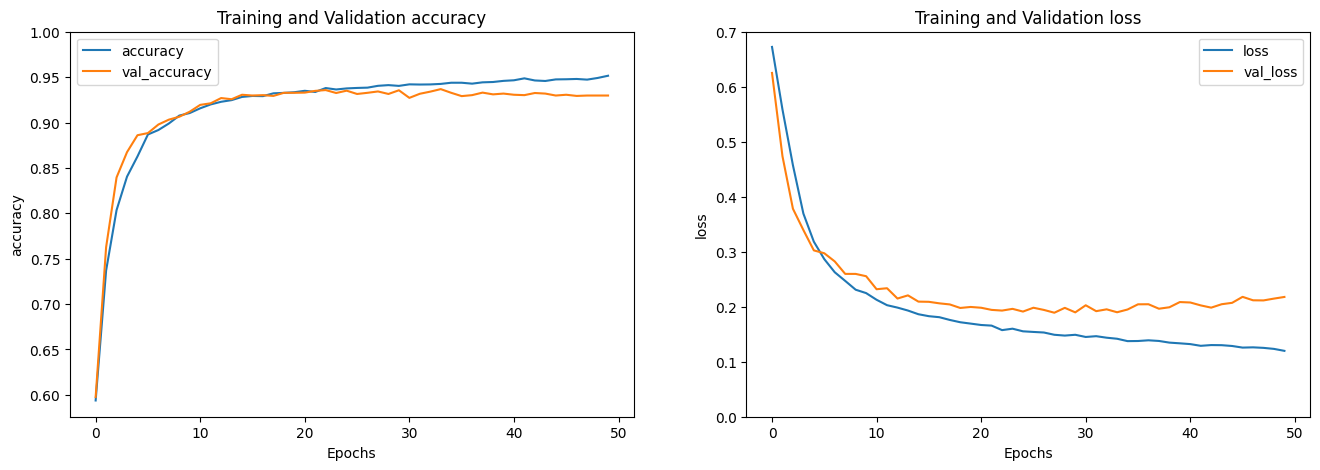

In [ ]:
### Binary Classification with Dropout 0.5
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
fig.savefig('Plotmetric.png')

## Predicting Grade Pending Restaurants (Z,P)



In [ ]:
path = 'cleanData2_withDummy.csv'
pred_rest = pd.read_csv(path).iloc[:,1:]
location = pd.read_csv(path).iloc[:,1:]
location = location[location.GRADE.isin(['P','Z'])]

In [ ]:
exclude_col = ['CAMIS','DBA','BORO','INSPECTION DATE','SCORE','INSPECTION TYPE','Latitude', 'Longitude','geometry']
cuision_new = []
for cui in pred_rest['CUISINE DESCRIPTION'].values:
    add = ''
    for k,v in cuision.items():
        if cui in v:
            add = add + k
    cuision_new.append(add)
pred_rest['CUISINE DESCRIPTION'] = cuision_new

pred_rest = pred_rest.loc[:,~pred_rest.columns.isin(exclude_col)]
pred_rest = pred_rest[pred_rest.GRADE.isin(['P','Z'])]

In [ ]:
X = pd.get_dummies(pred_rest.loc[:,~pred_rest.columns.isin(['GRADE'])])
X_pred = scaler.transform(X)

In [ ]:
prob = model.predict(X_pred)
pred_label = le.inverse_transform(prob.argmax(axis=1))

44/44 [==============================] - 0s 1ms/step


In [ ]:
pred_rest['Pred_Grade'] = pred_label
pred_rest = pred_rest[['CUISINE DESCRIPTION','Pred_Grade']]

In [ ]:
pred_rest

,CUISINE DESCRIPTION,Pred_Grade
18,Asian/Asian Fusion,Not A
19,Latin American,Not A
23,Protein,Not A
31,South European,Not A
34,Latin American,A
...,...,...
19987,Latin American,A
20000,Vegan/Fruit,Not A
20020,Vegan/Fruit,A
20042,South European,A


In [ ]:
location = location[['DBA','BORO','Latitude', 'Longitude']]
pred_df = pd.concat([location,pred_rest],axis=1)

In [ ]:
pred_df.to_csv('Prediction on Grade Z_P.csv',index=False)